### ДЗ к уроку 2. Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)

In [88]:
import pandas as pd

In [89]:
news = pd.read_csv("materials.csv")
news.head(3)

,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [90]:
news.shape

(27000, 2)

Загрузим пользователей и списки последних прочитанных новостей

In [91]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [92]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [93]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [94]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\irina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [95]:
stopword_ru = stopwords.words('russian')

morph = pymorphy2.MorphAnalyzer()

In [96]:
len(stopword_ru)

151

In [97]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [98]:
stopword_ru[:5]

['и', 'в', 'во', 'не', 'что']

In [99]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip("\n").strip("\r").strip("\t")
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub("n", ' ', text)
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [100]:
list(tokenize(news.iloc[0,1][:100], ))

[Substring(0, 11, 'Заместитель'),
 Substring(12, 24, 'председателя'),
 Substring(24, 25, 'n'),
 Substring(25, 38, 'правительства'),
 Substring(39, 41, 'РФ'),
 Substring(41, 42, 'n'),
 Substring(42, 48, 'Сергей'),
 Substring(48, 49, 'n'),
 Substring(49, 55, 'Иванов'),
 Substring(55, 56, 'n'),
 Substring(56, 62, 'избран'),
 Substring(63, 76, 'председателем'),
 Substring(77, 83, 'совета'),
 Substring(83, 84, 'n'),
 Substring(84, 87, 'ПБК'),
 Substring(88, 92, 'ЦСКА'),
 Substring(92, 93, 'n'),
 Substring(93, 94, '.'),
 Substring(95, 98, 'Как'),
 Substring(99, 100, 'с')]

In [101]:
norm_text = news.iloc[:2,1].apply(lambda x: clean_text(x), 1)

In [102]:
norm_text

0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
Name: title, dtype: object

In [103]:
norm_text[0]

'заместитель председателя правительства рф сергей иванов избран председателем совета пбк цска  как сообщает прессслужба армейцев такое решение было единогласно принято на первом заседании совета клуба основной функцией этого органа будет обсуждение текущего состояния планирование и утверждение стратегии развития клуба на ближайшую перспективу  в состав совета вошли георгий полтавченко полномочный представитель президента в центральном федеральном округе алексей седов генералполковник начальник службы по защите конституционного строя и борьбе с терроризмом фсб рф  александр новак заместитель министра финансов рф вячеслав полтавцев заместитель генерального директора руководитель блока по взаимодействию с органами власти социальной и корпоративной политики гмк норильский никель  леонид исакович генеральный директор ооо ук спортивные проекты ольга плешакова генеральный директор трансаэро  александр провоторов  генеральный директор оао ростелеком  андрей лопатов эксигрок цска чемпион мира т

In [104]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

Wall time: 17.9 s


In [105]:
' '.join(lemmatization(norm_text[0]))

'заместитель председатель правительство рф сергей иванов избрать председатель совет пбк цска сообщать прессслужба армеец решение единогласно принять первый заседание совет клуб основной функция это орган обсуждение текущий состояние планирование утверждение стратегия развитие клуб близкий перспектива состав совет войти георгий полтавченко полномочный представитель президент центральный федеральный округ алексей седов генералполковник начальник служба защита конституционный строй борьба терроризм фсб рф александр новак заместитель министр финансы рф вячеслав полтавец заместитель генеральный директор руководитель блок взаимодействие орган власть социальный корпоративный политика гмк норильский никель леонид исакович генеральный директор ооо ук спортивный проект ольга плешаков генеральный директор трансаэро александр провоторов генеральный директор оао ростелеком андрей лопат эксигрок цска чемпион мир трёхкратный чемпион европа баскетбол председатель правление банк клиентский андрей ватут

In [106]:
%%time
#Запускаем лемматизацию текста. Будет очень долго... 
# Лемматизация - перевод слов в первоначальную форму (именительный падеж и т.п.)
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 2min 50s


In [107]:
news[:5]

,doc_id,title
0,6,"[заместитель, председатель, правительство, рф,..."
1,4896,"[матч, финал, кубок, россия, футбол, приостано..."
2,4897,"[форвард, авангард, томаш, заборский, прокомме..."
3,4898,"[главный, тренер, кубань, юрий, красножанин, п..."
4,4899,"[решение, попечительский, совет, владивостокск..."


А теперь в 3 строчки обучим нашу модель

In [108]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [109]:
common_dictionary[40]

'обсуждение'

In [110]:
# common_dictionary.id2token

Делаем BoW по списку слов:

In [111]:
common_dictionary.doc2bow(['баскетбол', 'баскетбол', 'наше', 'все'], allow_update=True)

[(5, 2), (135723, 1), (135724, 1)]

In [112]:
common_corpus[0][0]

(0, 2)

In [113]:
len(texts[0])

118

Все просто - это словарь наших слов

Запускаем обучение

In [114]:
N_topic = 20 # число тем - гиперпараметр

In [115]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)#, passes=10)

Wall time: 23 s


In [116]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [117]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(1, 0.18486758), (6, 0.047692567), (10, 0.58759207), (18, 0.16158435)]

In [118]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: фонд российский экономика военный это технология россия
topic_1: ракета американский сша северный доклад офицер британский
topic_2: мозг врач спрос это ставка рынок вирус
topic_3: тело статья мужчина производитель летний тыс задержать
topic_4: человек который произойти результат погибнуть обнаружить несколько
topic_5: фестиваль треть рим гость поспособствовать алтай задерживать
topic_6: пенсия квартира канал предупредить лёд проверка бесплатный
topic_7: восток оборудование дальний отреагировать миллиардер устойчивость ирак
topic_8: это который дело год суд свой россия
topic_9: это мочь который свой весь время всё
topic_10: это который всё наука весь говорить путин
topic_11: японский годовой япония греция подсчитать японец лаборатория
topic_12: украина украинский это выяснить который век свой
topic_13: банк газ статья граница температура это рф
topic_14: россия это президент страна глава научный гражданин
topic_15: экипаж вода египет испытание запуск км маршрут
topic_16: взрыв 

Очень неплохо - большинство тем вполне можно описать о чем они.

Построим темы.

In [119]:
news['title'].iloc[5]

['ио',
 'главное',
 'тренер',
 'вячеслав',
 'буцай',
 'прокомментировать',
 'победа',
 'югра',
 'матч',
 'регулярный',
 'чемпионат',
 'кхл',
 'прежде',
 'весь',
 'хотеть',
 'поблагодарить',
 'свой',
 'ребята',
 'весь',
 'команда',
 'передавать',
 'слово',
 'официальный',
 'сайт',
 'югра',
 'игра',
 'начинаться',
 'очень',
 'удачно',
 'пропустить',
 'гол',
 'первый',
 'смена',
 'долго',
 'входить',
 'игра',
 'мочь',
 'это',
 'связать',
 'это',
 'дневный',
 'матч',
 'непривычный',
 'время',
 'плюс',
 'это',
 'третий',
 'матч',
 'сибирь',
 'гдеть',
 'ребята',
 'чувствовать',
 'скажем',
 'сонный',
 'второй',
 'третий',
 'период',
 'показать',
 'разбежаться',
 'стать',
 'играть',
 'правильно',
 'появиться',
 'момент',
 'дотерпеть',
 'считать',
 'заслуженно',
 'победить']

In [120]:
lda[common_dictionary.doc2bow(news['title'].iloc[10])]

[(3, 0.14393915),
 (12, 0.29342252),
 (16, 0.17186919),
 (17, 0.1409973),
 (18, 0.22472239)]

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [121]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [122]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]

In [123]:
topic_matrix.head()

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.000000,0.0,0.041318,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.056088,0.0,0.0,0.0,0.0,0.0
1,4896,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.136665,...,0.0,0.213519,0.415757,0.214008,0.000000,0.0,0.0,0.0,0.0,0.0
2,4897,0.000000,0.184849,0.0,0.000000,0.000000,0.0,0.047699,0.0,0.000000,...,0.0,0.000000,0.000000,0.161582,0.000000,0.0,0.0,0.0,0.0,0.0
3,4898,0.375233,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.072447,0.000000,0.0,0.0,0.0,0.0,0.0
4,4899,0.000000,0.000000,0.0,0.094104,0.062059,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [124]:
users.head(5)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"


In [125]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [126]:
doc_dict[293622]

array([0.        , 0.10700516, 0.        , 0.        , 0.07556015,
       0.        , 0.        , 0.        , 0.16241723, 0.        ,
       0.        , 0.        , 0.24129498, 0.07645043, 0.        ,
       0.        , 0.        , 0.28209245, 0.        , 0.04546629,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [167]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # user_vector = np.mean(user_vector, 0) # Пример на уроке с mean 
    # user_vector = np.median(user_vector, 0) # Для ДЗ меняем на median
    user_vector = np.max(user_vector, 0) # Для ДЗ меняем на max
    return user_vector

In [168]:
user_articles_list = users['articles'].iloc[33]

In [169]:
vv = get_user_embedding(user_articles_list)
vv

array([0.09549721, 0.08832406, 0.04695654, 0.04134076, 0.05528783,
       0.        , 0.        , 0.0308673 , 0.605425  , 0.19833694,
       0.22012526, 0.        , 0.01653543, 0.01459418, 0.4580847 ,
       0.01832038, 0.        , 0.62775356, 0.        , 0.18740287,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [170]:
import matplotlib.pyplot as plt

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [171]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [172]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера сообщать риа новость читать сообщение разговаривать автор сообщение знать откуда автор источник какихлибо основание подобный род репортаж знать откуда информация появиться сказать журналист итог встреча госсекретарь сша джон керри позиция свой изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать свой безопасность счёт безопасность продолжить министр слово лавров москва считать система нато создавать проблема наш безопасность поэтому декларация недостаточно мочь договариваться совместный система россия предлагать ещё начинать год президент путин посещать сша нужно вести речь очередной декларация гарантия который проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенциал под

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [173]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.107005,0.018939,0.238576,0.271620,0.012904,0.000000,0.024202,0.407917,...,0.010775,0.021741,0.638413,0.084378,0.045466,0.0,0.0,0.0,0.0,0.0
1,u108690,0.068484,0.054476,0.067090,0.107168,0.250979,0.000000,0.000000,0.000000,0.467076,...,0.000000,0.019951,0.379647,0.000000,0.058193,0.0,0.0,0.0,0.0,0.0
2,u108339,0.058908,0.000000,0.070019,0.164054,0.385155,0.000000,0.023543,0.000000,0.335938,...,0.013796,0.000000,0.361204,0.016353,0.155413,0.0,0.0,0.0,0.0,0.0


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [174]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [175]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.107005,0.018939,0.238576,0.271620,0.012904,0.000000,0.024202,0.407917,...,0.021741,0.638413,0.084378,0.045466,0.0,0.0,0.0,0.0,0.0,0
1,u108690,0.068484,0.054476,0.067090,0.107168,0.250979,0.000000,0.000000,0.000000,0.467076,...,0.019951,0.379647,0.000000,0.058193,0.0,0.0,0.0,0.0,0.0,1
2,u108339,0.058908,0.000000,0.070019,0.164054,0.385155,0.000000,0.023543,0.000000,0.335938,...,0.000000,0.361204,0.016353,0.155413,0.0,0.0,0.0,0.0,0.0,1


In [176]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [177]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [178]:
logreg = LogisticRegression(C=1.0)
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [179]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22241219, 0.00738356, 0.68728623, 0.37245405, 0.0085652 ,
       0.01769892, 0.32866439, 0.21419949, 0.00613984, 0.05118827])

In [180]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

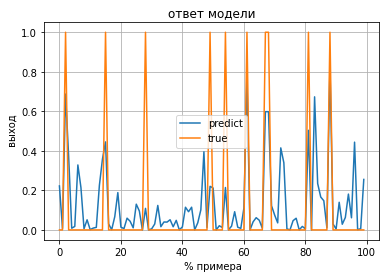

In [181]:
plt.plot(preds[:100], label = 'predict')
plt.plot(y_test.values[:100], label = 'true')
plt.title('ответ модели')
plt.xlabel(' % примера')
plt.ylabel(' выход')
plt.legend()
plt.grid('On')
plt.show()

In [182]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
roc_auc = roc_auc_score(y_test, preds)

# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'best threshold = {round(thresholds[ix],2)}, f-score = {round(fscore[ix], 2)}, precision = {round(precision[ix], 2)}, recall = {round(recall[ix], 2)}, roc_auc_score = {round(roc_auc, 2)}, ')


best threshold = 0.28, f-score = 0.71, precision = 0.64, recall = 0.79, roc_auc_score = 0.95, 


In [183]:
cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
cnf_matrix

array([[1647,  108],
       [  52,  193]], dtype=int64)

In [184]:
df = pd.DataFrame({'thresholds': [round(thresholds[ix],2)], 'precision': [round(precision[ix], 2)],
                   'recall': [round(recall[ix], 2)], 'fscore': [round(fscore[ix], 2)],
                   'roc_auc': [round(roc_auc, 2)]}, 
                   columns=['thresholds', 'precision', 'recall', 'fscore', 'roc_auc'])
# df.index = ['mean']
# df.index = ['median']
df.index = ['max']

In [185]:
# df_rez = df # для 1й итерации с mean
df_rez = pd.concat([df_rez, df], axis=0) # для итераций с median и max

In [186]:
df_rez

,thresholds,precision,recall,fscore,roc_auc
mean,0.25,0.56,0.73,0.63,0.93
median,0.25,0.65,0.79,0.71,0.95
max,0.28,0.64,0.79,0.71,0.95


## Вывод:
Вариант с медианой показывает метрики выше варианта со средним значением векторов, т.к. медиана лучше обходит т.н. выбросы.
Вариант с максимумом показывает метрики выше, т.к. отбирает топики с бОльшей значимостью (весом).

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 4 разных методов получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf